Exerise:

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening.

Bonus:

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff?

- - -

## Detecting time series anomalies

In [43]:
#Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from env import get_connection

### Read in the data from Codeup SQL server

In [44]:
#Define query
query = '''
        SELECT *
        FROM logs
        '''

In [45]:
#Define url
url = get_connection('curriculum_logs')

In [46]:
#Read data from SQL server
df = pd.read_sql(query, url)
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [47]:
#Cache
df.to_csv('curriculum_logs.csv')

So far, data pulled from SQL server and saved locally as a csv file

### pd.to_what?

In [48]:
#Change date to datetime object
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.dtypes

date         datetime64[ns]
time                 object
path                 object
user_id               int64
cohort_id           float64
ip                   object
dtype: object

In [49]:
#Set as index
df = df.set_index('date')
df.head()

,time,path,user_id,cohort_id,ip
date,,,,,
2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [50]:
#Resample the data by day and count the number of hits each day
daily_hits = df['path'].resample('d').count()
daily_hits.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

'date' column datatype was changed to datetime, then set as the index, then dataframe was assigned to a new df name and resampled  by day calculating the total observations per day

### Exponential moving average

Simple moving average has a lag associated with it

Exponential moving average minimizes the lag by weighting recent points more heavily

We will use the pandas ewm (Exponential Weighted Calculations) method to assist us

We will have to define the span argument for how many observations we will include in the calculation. We will try a few different spans to see how it affects the smoothness of the moving average

In [51]:
#Define weekly average with span=7
weekly_avg = daily_hits.ewm(span=7).mean()
weekly_avg.head()

''' 
creates a series named weekly_avg which shows the exponential moving average by finding the average of exponential weighted calculations, span is 7 days
'''

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: path, dtype: float64

In [52]:
#Define monthly average
monthly_avg = daily_hits.ewm(span=30).mean()
monthly_avg.head()
''' 
Does the same as above except span is 30 days
'''

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [53]:
#Define quarterly average
quarterly_avg = daily_hits.ewm(span=90).mean()
quarterly_avg.head()
''' 
Same as above except the span is 90 days
'''

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: path, dtype: float64

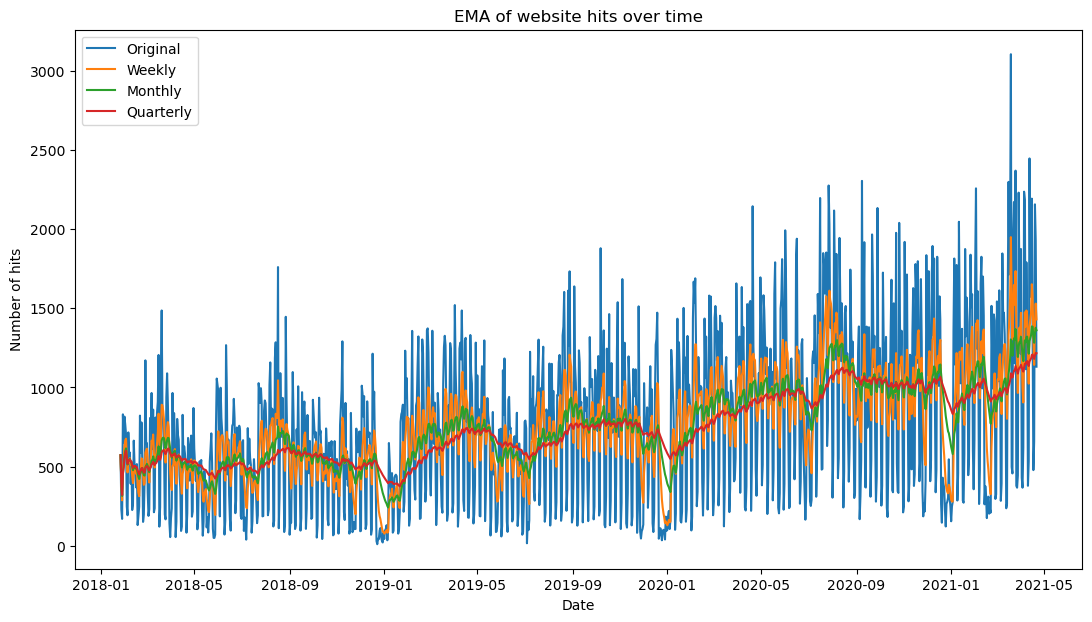

In [54]:
#Plot the exponential moving averages to see effects
plt.figure(figsize=(13, 7))
plt.plot(daily_hits, label='Original')
plt.plot(weekly_avg, label='Weekly')
plt.plot(monthly_avg, label='Monthly')
plt.plot(quarterly_avg, label='Quarterly')
plt.xlabel('Date')
plt.ylabel('Number of hits')
plt.title('EMA of website hits over time')
plt.legend()
plt.show()

''' 
takes the variables created in the previous few cells and plots them on the same graph showing the exponential
moving average over time by weekly, monthly, and quarterly.  the Original plot is very noisy, as it is resampled
it becomes less noisy.
'''

### Bollinger Bands

Bollinger bands are used to indicate volatility in price over time, often used to detect 100-baggers in the stock market

Bollinger bands have three parts: lower band, upper band, and midband

The midband is the exponential moving average for a defined period

The upper and lower bands are calculated using the following formula:  
Midband +/- Standard Deviation * K

for an example, think about when using bollinger bands on the td ameritrade app.

In [55]:
#We have our midband already!
monthly_avg.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [56]:
#Compute exponential weighted standard deviation
monthly_std = daily_hits.ewm(span=30).std()
monthly_std.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: path, dtype: float64

In [57]:
#Compute upper and lower bands
upper_band = monthly_avg + monthly_std * 1.5
lower_band = monthly_avg - monthly_std * 1.5

''' 
This is calculating the upper and lower bollinger bands which will be shown on the graph.
'''

In [58]:
#Create final df
final_df = pd.concat([daily_hits, monthly_avg, upper_band, lower_band], axis=1)
final_df.head()

''' 
combining everything into 1 dataframe
'''

,path,path,path,path
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221
2018-01-28,170,315.139578,635.956785,-5.677629
2018-01-29,830,457.002386,931.704142,-17.699369
2018-01-30,652,501.369064,928.088655,74.649474


In [59]:
#Rename columns
final_df.columns = ['hits', 'midband', 'upper_band', 'lower_band']
final_df.head()

''' 
columns in the new dataframe are being renamed since before this they were all named 'path'
'''

,hits,midband,upper_band,lower_band
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221
2018-01-28,170,315.139578,635.956785,-5.677629
2018-01-29,830,457.002386,931.704142,-17.699369
2018-01-30,652,501.369064,928.088655,74.649474


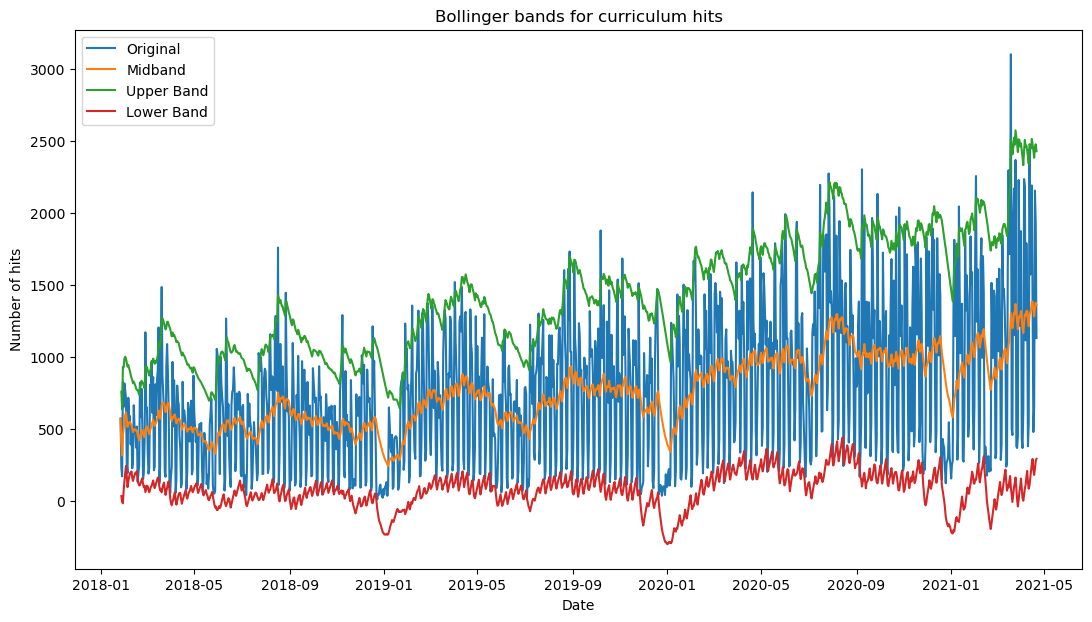

In [60]:
#Plot the bands
plt.figure(figsize=(13, 7))
plt.plot(final_df['hits'], label='Original')
plt.plot(final_df['midband'], label='Midband')
plt.plot(final_df['upper_band'], label='Upper Band')
plt.plot(final_df['lower_band'], label='Lower Band')
plt.xlabel('Date')
plt.ylabel('Number of hits')
plt.title('Bollinger bands for curriculum hits')
plt.legend()
plt.show()

''' 
The original is the same as above but instead of showing the exponential moving average at different time spans, 
it is now showing the bollinger bands.  Values above the upper band (green line) or below the lower band (red line) 
may be outliers and may require further investigation.
'''

### %b

The %b defines where a value lays relative to the bands

The formula for %b is: (last - Lower Band) / (Upper Band - Lower Band)

A value greater than 1 lies above the Upper Band, and a value less than 0 lies below the Lower Band

In [61]:
#Try the formula with our df
(final_df['hits'] - final_df['lower_band']) / (final_df['upper_band'] - final_df['lower_band'])

''' 
calculates where a point is in relation to the upper and lower bands.  1 is on the upper band (>1 is above upper band), 0 is on the lower band 
 negative value is below lower band)
'''

date
2018-01-26         NaN
2018-01-27    0.272154
2018-01-28    0.273797
2018-01-29    0.892876
2018-01-30    0.676499
                ...   
2021-04-17    0.118394
2021-04-18    0.217310
2021-04-19    0.866464
2021-04-20    0.751201
2021-04-21    0.392491
Freq: D, Length: 1182, dtype: float64

In [62]:
#Make new column for %b in df
final_df['pct_b'] = (final_df['hits'] - final_df['lower_band']) / (final_df['upper_band'] - final_df['lower_band'])
final_df.head()

''' 
creating a new column to display the value of %b
'''

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,758.045779,32.554221,0.272154
2018-01-28,170,315.139578,635.956785,-5.677629,0.273797
2018-01-29,830,457.002386,931.704142,-17.699369,0.892876
2018-01-30,652,501.369064,928.088655,74.649474,0.676499


In [63]:
#Check for anomalies on the high side
final_df[final_df['pct_b'] > 1].sort_values('pct_b', ascending=False).head()

''' 
pulling all observations that are outside the upper band (greater than 1) then sorts them with the 
highest value first and shows the first 5 rows
'''

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2018-02-27,1171,496.375166,932.523281,60.227052,1.273390
2018-08-17,1760,751.910516,1429.611841,74.209191,1.243756
2021-03-19,3104,1303.128816,2515.100114,91.157519,1.242951
2019-01-28,1232,447.643274,988.064736,-92.778188,1.225690
2019-10-07,1879,803.738383,1545.169017,62.307748,1.225126


In [64]:
#Low side anomalies
final_df[final_df['pct_b'] < 0].sort_values('pct_b').head()

''' 
Does the same as above but instead of outside upper bound this is pulling rows that fall outside the lower bound.
'''

,hits,midband,upper_band,lower_band,pct_b
date,,,,,
2020-08-15,242,1205.934214,2098.302641,313.565786,-0.040099
2019-05-18,65,702.368176,1293.763070,110.973281,-0.038869
2020-09-05,168,985.144395,1746.086017,224.202772,-0.036930
2020-05-09,201,1005.779622,1755.608291,255.950954,-0.036642
2020-03-14,123,929.729604,1684.087680,175.371528,-0.034713


In [65]:
def compute_bollinger(series, column, span, k):

    ''' 
    takes the work done above for calculating bollinger bands and puts it into a function.
    '''

    mean_df = series.ewm(span=span).mean()
    std_df = series.ewm(span=span).std()
    upper_band = mean_df + std_df * k
    lower_band = mean_df - std_df * k
    final_df = pd.concat([series, mean_df, upper_band, lower_band], axis= 1)
    final_df.columns = [column, 'midband', 'ub', 'lb']
    final_df['pct_b'] = (final_df[column] - final_df['lb']) / (final_df['ub'] - final_df['lb'])

    return final_df


In [66]:

daily_hits.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

In [71]:
#calling the function and verifying that it does what is expected/wanted
boll = compute_bollinger(daily_hits, 'hits', 14, 2)
boll

,hits,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,388.785714,872.446753,-94.875324,0.335850
2018-01-28,170,305.208829,725.773959,-115.356302,0.339253
2018-01-29,830,465.757252,1116.800959,-185.286456,0.779738
2018-01-30,652,514.347700,1087.037023,-58.341623,0.620181
...,...,...,...,...,...
2021-04-17,478,1348.173718,2797.497736,-101.150300,0.199800
2021-04-18,659,1256.283889,2690.471058,-177.903279,0.291769
2021-04-19,2156,1376.246037,2854.618836,-102.126761,0.763720
